In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from sharc.utils import readJson
import itertools
from math import nan

# def plot_multiple_time_series(axs, x, t, x_names, color=None):
# 
#     for i, name in enumerate(x_names):
#         ax_row = i // 2
#         ax_col = i %  2
#         ax = axs[ax_row, ax_col]
#         if color:
#             ax.plot(t, x[:, i], label=name, c=color)
#         else:
#             ax.plot(t, x[:, i], label=name)
#         ax.set_xlabel('Time [s]')
#         ax.set_ylabel(name)
#         ax.grid(True)

def plot_time_series(ax, x, t, name, color=None):
    if color:
        ax.plot(t, x, label=name, c=color)
    else:
        ax.plot(t, x, label=name)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel(name)
    ax.grid(True)

def plot_x_vs_t(axs, sim_data, x_names, color=None):
    x = np.array(sim_data['x'])
    t = np.array(sim_data['t'])
    plot_time_series(axs, x, t, x_names, color)

def plot_u_vs_t(axs, sim_data, x_names, color=None):
    x = np.array(sim_data['u'])
    t = np.array(sim_data['t'])
    plot_time_series(axs, x, t, x_names, color)

def plot_experiment_results(experiment_paths):
    for experiment_path in experiment_paths:
        experiment_path = os.path.abspath(experiment_path)
        # experiment_results = load_experiment_data(experiment_path)
        experiment_results = readJson('latest/serial-fake/experiment_data.json')

        config = experiment_results["config"]["system_parameters"]
        x_names = config['x names']
        sample_time = config["sample_time"]
        n_states = len(x_names)
        n_rows = 2
        n_cols = (n_states) // 2 + 1

        fig, axs = plt.subplots(2, n_cols, figsize=(4 * n_cols, 6), squeeze=False)

        for batch in experiment_results["batches"]:
            sim_data = batch['valid_simulation_data']
            plot_x_vs_t(axs, sim_data, x_names)

            t = np.array(sim_data["t"])
            u = np.array(sim_data["u"])
            pc_t, pc_u, pc_delay = [], [], []

            for pc in sim_data["pending_computation"]:
                if pc:
                    pc_t.extend([float(pc["t_start"]), float(pc["t_start"]) + float(pc["delay"]), np.nan])
                    pc_u.extend([float(pc["u"][0]), float(pc["u"][0]), np.nan])
                    pc_delay.extend([float(pc["delay"]), float(pc["delay"]), np.nan])

            axs[0, -1].plot(t, u, label='Control')
            axs[0, -1].plot(pc_t, pc_u, linestyle=':', label='Pending Control')
            axs[0, -1].set_title("Control")
            axs[0, -1].set_xlabel('Time')
            axs[0, -1].grid(True)

            axs[1, -1].plot(pc_t, pc_delay, label='Delays')
            axs[1, -1].set_title("Delays")
            axs[1, -1].set_xlabel('Time')
            axs[1, -1].grid(True)

        fig.suptitle(f'States, Control, and Delays (Sample Time: {sample_time}s)', fontsize=16)
        plt.tight_layout()
        fig.subplots_adjust(top=0.9)
        plt.show()

        image_path = os.path.join(experiment_path, f'states_and_control_sample_time_{sample_time}.png')
        fig.savefig(image_path)
        print(f'Plot saved at: {image_path}')

def plot_experiment_result(result_data, velocity_ax, headway_ax, delay_ax, control_ax, color):
    t = np.array(result_data["t"])
    u = np.array(result_data["u"])
    x = np.array(result_data["x"])
    w = np.array(result_data["w"])
    h = x[:, 1]
    v = x[:, 2]
    # norm = np.sqrt(np.sum(np.array(x)[:, :2]**2, axis=1))

    velocity_ax.plot(t, v, label=None, c=color)
    headway_ax.plot(t, h, label=None, c=color)
    # plot_time_series(velocity_ax, v, t, name=None, color=color)
    # plot_time_series(headway_ax, h, t, name=None, color=color)
    
    pc_t, pc_delay = [], []
    for pc in result_data["pending_computations"]:
        if pc:
            t_start = float(pc["t_start"])
            delay = float(pc["delay"])
            pc_t.extend([t_start, t_start + delay, np.nan])
            pc_delay.extend([delay, delay, np.nan])
    delay_ax.plot(pc_t, pc_delay, color=color)
    
    control_ax.plot(t, u[:,0], color=color, linestyle='-')
    control_ax.plot(t, u[:,1], color=color, linestyle=':')

    # Plot batch starting points in the state plot.
    if result_data["batches"] is not None:
        for batch in result_data["batches"]:
            start_time = batch['valid_simulation_data']["t"][0]
            idx = np.where(t == start_time)[0][0]
            velocity_ax.plot(t[idx], v[idx], 'kx', markersize=4)
            headway_ax.plot(t[idx], h[idx], 'kx', markersize=4)
    
# Set global font sizes\n",
plt.rcParams.update({
    'font.size': 19,
    'axes.titlesize': 21,
    'axes.labelsize': 19,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18,
})

def plot_experiment_list(experiment_list):
    colors = iter(plt.cm.tab10.colors)
    
    n_axs = 4
    fig, axs = plt.subplots(n_axs, 1, figsize=(10, 13), sharex=True)
    plts_for_bottom_legend = []
    velocity_ax = axs[0]
    headway_ax  = axs[1]
    delay_ax    = axs[2]
    control_ax  = axs[3]
    for experiment in experiment_list:
      label = experiment[0]
      result = experiment[1]
      result_data = result["experiment data"]
      color = next(colors)
      try:
        plot_experiment_result(result_data, velocity_ax=velocity_ax, headway_ax=headway_ax, delay_ax=delay_ax, control_ax=control_ax, color=color)
      except Exception as err:
        raise Exception(f'Failed to plot {result["label"]}') from err
    
      # Plot invisible point to use in creating the legend.
      line = velocity_ax.plot(nan, nan, c=color)[0]
      plts_for_bottom_legend.append((line, label))
    
    sample_time = result["experiment config"]["system_parameters"]["sample_time"]
    d_min = result["experiment config"]["system_parameters"]["d_min"]
    w = np.array(result_data["w"])
    u = np.array(result_data["w"])
    v_front = w[:,0]
    t = np.array(result_data["t"])

    # Plot velocity of front vehicle.
    velocity_ax.plot(t, v_front, label="Front Velocity", color='black')
    # Plot sample time
    delay_ax.axhline(y=sample_time, color='black', linestyle='--', linewidth=2, label = f"Sample Time ({sample_time} s)")
    # Plot minimum headway.
    headway_ax.axhline(y=d_min, color='black', linestyle='--', linewidth=2, label = "Minimum Headway $d_{min}$")
    
    control_ax.plot(nan, nan, label="Acceleration Force", color="black", linestyle='-')
    control_ax.plot(nan, nan, label="Braking Force", color="black", linestyle=':')

    # Add legend entry for batch starts.
    batch_start_markers = velocity_ax.plot(nan, nan, 'kx', markersize=4)[0]
    plts_for_bottom_legend.append((batch_start_markers, "Batch start"))

    xlim = (0, result_data["t"][-1])

    # Velocity Axis
    velocity_ax.set(
          ylabel='Velocity $v$ [m/s]', 
          # yscale='log', 
          title='Velocity', 
          xlim=xlim, 
          ylim=(0, None)
        )
    velocity_ax.grid(True)
    velocity_ax.legend()

    # Headway Axis
    headway_ax.set(
          ylabel='Headway $h$ [m]', 
          # yscale='log', 
          title='Headway', 
          xlim=xlim,
          ylim=(0, None)
        )
    headway_ax.grid(True)
    headway_ax.legend()
    
    # Delays Axis
    delay_ax.set(
        ylabel='Delay $\\tau$ [s]', 
        title='Delays', 
        xlim=xlim, 
        # yscale='log', 
      #  ylim=(0,1.6)
    )
    delay_ax.grid(True)
    delay_ax.legend()
    
    # Control Axis
    control_ax.set(
        xlabel='Time [s]', 
        ylabel='Control Input $u$ [N]', 
        title='Control', 
        xlim=xlim, 
        # ylim = [-147, 147]
      )
    control_ax.grid(True)
    control_ax.legend()
    
    fig.legend(*zip(*plts_for_bottom_legend), 
              loc='lower center',
              bbox_to_anchor=(0.55, 0.12),
              ncol=4,
              columnspacing=1.0,
              handlelength=1.5,
              handletextpad=0.5,
              bbox_transform=fig.transFigure,
              borderaxespad=0.2)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.23)
    plt.show()

{'fake-delays/parallel': {'label': 'fake-delays/parallel', 'experiment directory': '/dev-workspace/examples/acc2_example/experiments/fake-delays--2024-11-21--02-27-35/parallel', 'experiment wall time': 1.9188811779022217, 'experiment data': {'k': [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 33, 34, 34, 35, 35, 36, 36, 37, 37, 38, 38, 39, 39], 'i': [0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 33, 34, 34, 35, 35, 36, 36, 37, 37, 38, 38, 39, 39, 40], 't': [0.0, 0.2, 0.2, 0.4, 0.4, 0.6000000000000001, 0.6000000000000001, 0.8, 0.8, 1.0, 1.0, 1.2000000000000002, 1.2000000000000002, 1.4000000000

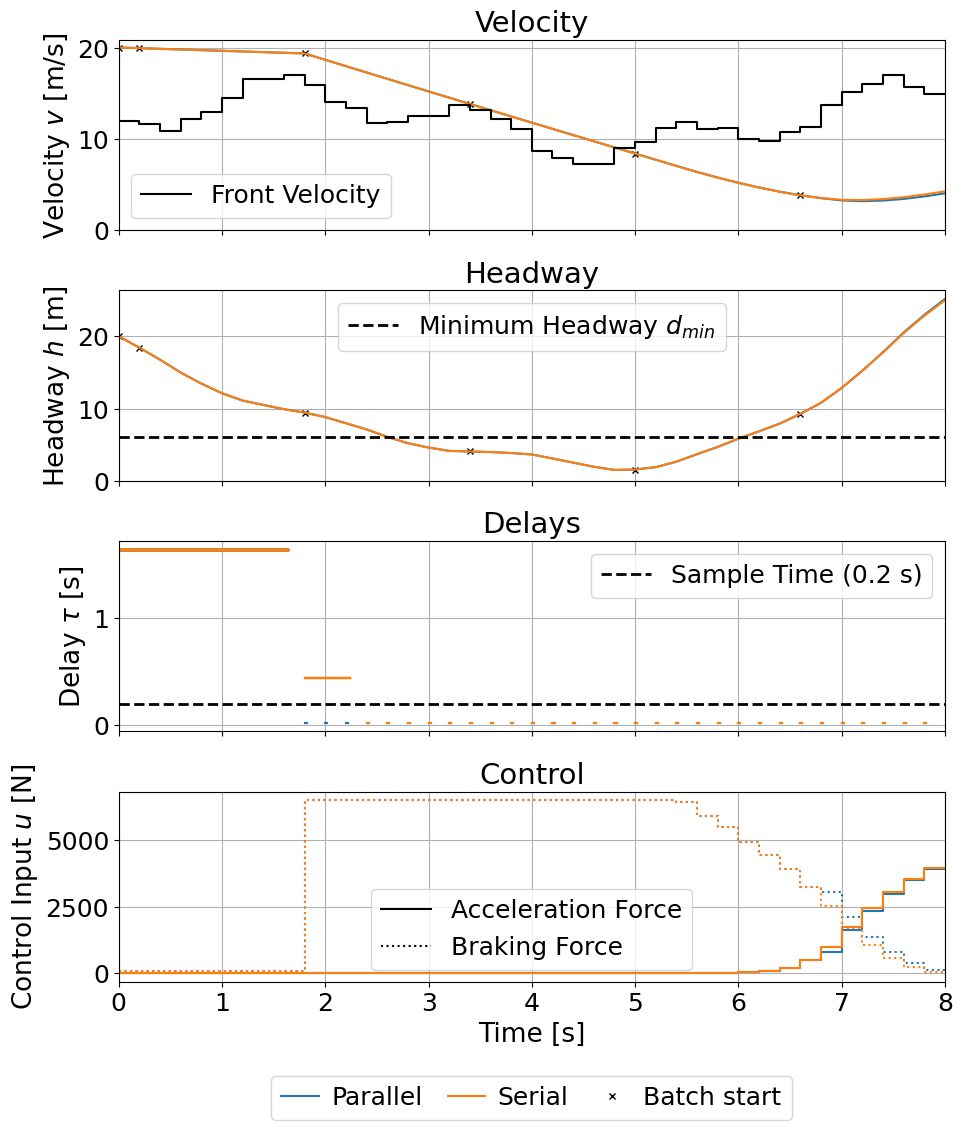

In [106]:
# experiment_paths = ["libmpc_docker/examples/cartpole/experiments/parallel-08--2024-11-11--06-39-37/parallel/", "libmpc_docker/examples/cartpole/experiments/parallel-079--2024-11-11--13-34-44/parallel/", "libmpc_docker/examples/cartpole/experiments/parallel-075--2024-11-11--12-04-46/parallel/"]
# plot_experiment_results(experiment_paths)
# labels = ['800 MHz', '790 MHz', '750 MHz']
# plot_experiment_list([], labels)

from sharc.utils import printJson


result_list = readJson('latest/experiment_list_data_incremental.json')
# printJson("result_list", result_list)
results = []
# results.append(("Parallel (Fake Delays)", result_list["parallel-vs-serial/parallel-fake"]))
# results.append(result_list["parallel-vs-serial/parallel-scarab"])
# results.append(("Serial (Fake Delays)", result_list["parallel-vs-serial/serial-fake"]))
# results.append(("Parallel", result_list["parallel-vs-serial/parallel-scarab"]))
# results.append(("Serial", result_list["parallel-vs-serial/serial-scarab"])) #?? Why does having more debugging statements take less time?
# results.append(("Serial", result_list["parallel-vs-serial/parallel-scarab-w-less-debugging"]))
###### Fake Delays ########
print(result_list)
for key, val in result_list.items():
  results.append((val["experiment config"]["label"], val))
plot_experiment_list(results)